## Project 5: Vehicle Detection
The objective of this project is to extract features from a forward facing camera image and train & utilize a classifier to detect nearby vehicles in the image and bound and track them in a video.

In [1]:
# import some necessary packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
%matplotlib inline

### Calibrate Camera using Project 4: Lane Detection routines

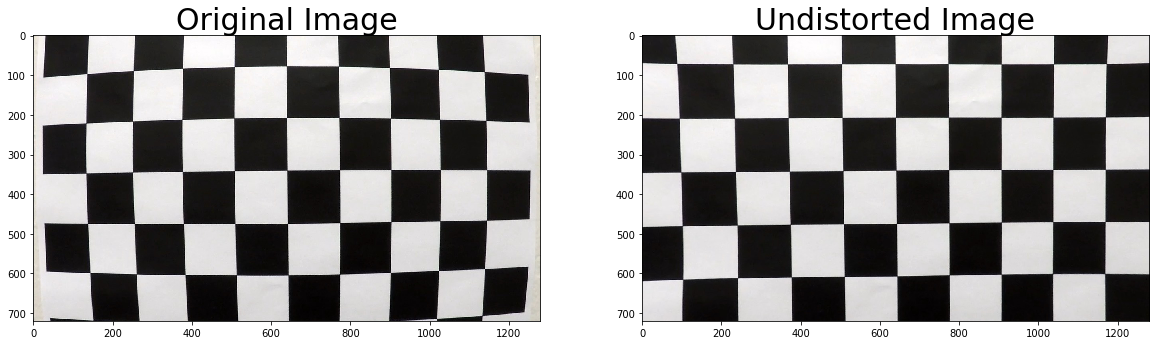

In [2]:
from camera_prep import calibrate, get_dist_mtx
images, objpoints, imgpoints = calibrate('camera_cal/ca*.jpg', 9, 6)
# verify distortion correction appears correct
# Use calibration data to correct distortion
image = mpimg.imread('camera_cal/calibration1.jpg')
undistort, mtx, dist = get_dist_mtx(objpoints, imgpoints, image)

## **Feature Extraction**

***Color Space***: Based on experimentation with various color spaces including RGB, YUV, HSV, and YCrCb during the lesson I settled on using YCrCb for feature extraction as it provided the best accuracy for a given set of feature extraction parameters.

***Features***: As in the lesson I decided to used a combination of HOG, spatial, and color histogram features.  These are concatenated into a feature vector.

***HOG Features***:

* All channels of the YCrCb color space are used for HOG feature extraction as this provided better accuracy than just the Y channel even though that was effective on its own.
* Experimenting with different HOG parameters I settled on the following as providing the best accuracy with reasonable computation time.  With additional time it's possible these parameters could be further optimized.
    * orientation: 12
    * pixels per cell: 12
    * cells per block: 4
* HOG features are extracted once for the region of interest in the image and then subsampled with sliding windows rather than extracting for each window to reduce computation

## **Classifier Training**

***Support Vector Machine Classifier***: I chose to use a Support Vector Machine (SVM) as the classifier for this project similar to what we did in the lesson.  In particular, I used a linear SVM by utilizing the LinearSVC class from sklearn.  

***Pre-processing prior to training***: Features were scaled to zero mean and unit variance before training the classifier by utilizing sklearns StandarScaler

***Test Accuracy of SVC =  0.9893***

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from get_features import extract_features
from sklearn.model_selection import train_test_split  # running sklearn 0.18
# for scikit-learn <= 0.17 use:
#from sklearn.cross_validation import train_test_split

In [9]:
# Read in cars and notcars
car_files = glob.glob('training_data/vehicles/*/*.png')
notcar_files = glob.glob('training_data/non-vehicles/*/*.png')
cars = []
notcars = []
for file in car_files: cars.append(file)
for file in notcar_files: notcars.append(file)

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 12 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 3120
13.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


In [12]:
print(len(cars), "vehicles used for training", len(notcars), "non-vehicles used")

8792 vehicles used for training 8968 non-vehicles used


## **Save Classifier**:
The Classifier class is used to store the key Classifier parameters and save the classifier via pickle for future use so it doesn't have to be retrained

In [18]:
from Classifier import Classifier
car_classifier = Classifier(svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

In [21]:
# save the data from training the classifier in case we need to import it later
# can be read with
# car_classifier = pickle.load( open( "classifier.p", "rb" ) )
pickle.dump(car_classifier, open( "classifier.p", "wb" ) )

In [3]:
# load the saved classifier data
from Classifier import Classifier
cc = pickle.load(open("classifier.p", "rb"))

In [4]:
# import feature classification routines
from get_features import *
# import image search and sliding window routines for car classification
from find_cars import *
# import the helpers to draw bounding boxes, overlays etc
from image_helpers import *
# import the vehicle tracker object for state storage
from VehicleTracker import *
# import the processing pipeline
from pipeline import *



## **Vehicle Identification**

***Sliding Window Search With The Classifier***:A sliding window search was implemented to identify vehicles in the image frame.  I chose to use 4 different scales and overlaps.  The idea was to detect different vehicle sizes in the image since they will change based on distance away from our camera.  I experimented with scales from 0.5 to 3 and settled on 4 scales/overlaps between 1 & 2 as the most robust detection vs. false positive tradeoff.  Scales <=1.5 were limited to the upper portion of the road in the frame and scale 2 only scanned the lower part of the frame since this is where target vehicle sizes were likely to appear.  See pipeline.py for the specific implementation. 

***Reducing false positive detection***: Several methods were incorporated for reducing false positive detection:
* thresholding: heatmaps of classifier detections were thesholded
* aspect ratio analysis: I eliminated detections with an aspect ration with y >2.5 x as these are unlikely to be a car
* intersecting/overlapping detection confidence increase: when bounding boxes overlapped I increased the "heat" or confidence that this these were car detections.  See increase_heat in image_helpers.py.
* For video, heatmap detections are summed over 20 frames using a deque in the VehicleClassifier object.  While the object collected bounding boxes & thesholded maps as well I didn't use these in the current implementation.  This averaging over multiple frames allows elimination of false positives but does have the downside of delaying initial detection of new vehicles entering the frame in some cases as well as causing the outline bounding box to "trail" vehicles slightly since the new pixel detections where a vehicle has moved to in the most recent frame may not be create enough heat to be bounded for several frames.

***Merging multiple detections***: to merge multiple overlapping detections, the label() function from scipy.ndimage.measurements  is utilized.  This provides a labeled matrix with overlapping detections merged from which we calculate and draw the bounding boxes with draw_labeled_bboxes() in image_helpers.py

***The examples below show vehicle bounding after false positive elimination and merging multiple detections as well as the initial detection output from the classifier during experimentation.***

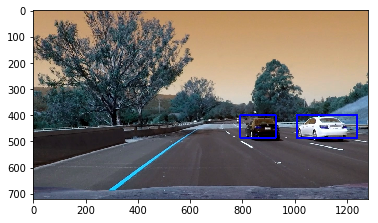

In [225]:
labeled_boxes = draw_labeled_bboxes(np.copy(img), labels)
plt.imshow(labeled_boxes)

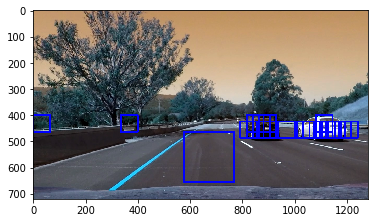

In [226]:
plt.imshow(draw_boxes(np.copy(img),out_win))

## **Video Implementation**
***VehicleTracker Class to track state***: To track state throughout the video, a class VehicleTracker is implemented.  This allows us to track hot zones across frames to help eliminate false positives across frames and display the interim output in an overlay over the frame.

***Heatmap tracking across frames***: As noted previously, heatmap detections are summed over 20 frames using a deque in the VehicleClassifier object.  While the VehicleTracker object collected bounding boxes & thesholded maps as well I didn't use these in the current implementation.  This averaging over multiple frames allows elimination of false positives but does have the downside of delaying initial detection of new vehicles entering the frame in some cases as well as causing the outline bounding box to "trail" vehicles slightly since the new pixel detections where a vehicle has moved to in the most recent frame may not be create enough heat to be bounded for several frames.  The overlay displayed in the frame below shows heatmap detections for:
* The current frame
* The sum of the deque across 20 frames(or up to 20 for the early frames in the video).
* The thresholded sum which is what I use to calculate the bounding boxes.  A threshold of 20 across the 20 frames was the final one I chose as a good tradeoff between false positive elimination and reasonable vehicle bounding after experimenting above & below that number.

processing file: test1.jpg
writing:  test_image_output/out_test1.jpg
processing file: test2.jpg
writing:  test_image_output/out_test2.jpg
processing file: test3.jpg
writing:  test_image_output/out_test3.jpg
processing file: test4.jpg
writing:  test_image_output/out_test4.jpg
processing file: test5.jpg
writing:  test_image_output/out_test5.jpg
processing file: test6.jpg
writing:  test_image_output/out_test6.jpg


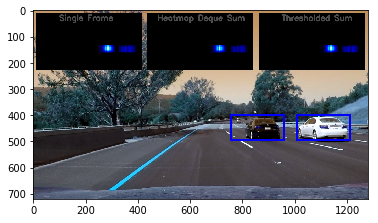

In [5]:
for i in range(1,7):
    # reinstantiate cars for every image since we don't want to average as we do in a video
    # had to recreate this in the notebook since I had changed the code from the original single
    # frame vehicle identification and the heatmaps are now averaged over multiple frames
    # this simulates each image being the first frame of a video
    cars = VehicleTracker(cc.classifier, cc.scaler, cc.color_space, cc.pix_per_cell,
                          cc.cell_per_block, cc.spatial_size, cc.hist_bins, threshold=0)
    file = 'test{}.jpg'.format(i)
    print("processing file:", file)
    img = cv2.imread('test_images/' + file)
    out_img = cars.process_image(img)
    image_out = 'test_image_output/out_' + file
    print("writing: ", image_out)
    mpimg.imsave(image_out, out_img)
plt.imshow(out_img)

### The above image gives an example of the overlay with appropriate threshold for bounding.  Note this is a single image so the deque has only 1 frame.

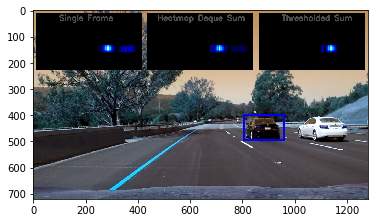

In [6]:
# NOTE: below color_space should be orient but the classifier save has a bug where orient & color_space are swapped
cars = VehicleTracker(cc.classifier, cc.scaler, cc.color_space, cc.pix_per_cell, cc.cell_per_block, cc.spatial_size, 
                      cc.hist_bins, threshold=5, cspace='BGR2YCrCb')
img = cv2.imread('test_images/test6.jpg')
out = cars.process_image(img)
plt.imshow(out)

### The above image gives an example of the overlay with high threshold for bounding so one vehicle is not bounded.  Note this is a single image so the deque has only 1 frame.

processing file: Thresh_image_1.png
processing file: Thresh_image_2.png
processing file: Thresh_image_3.png


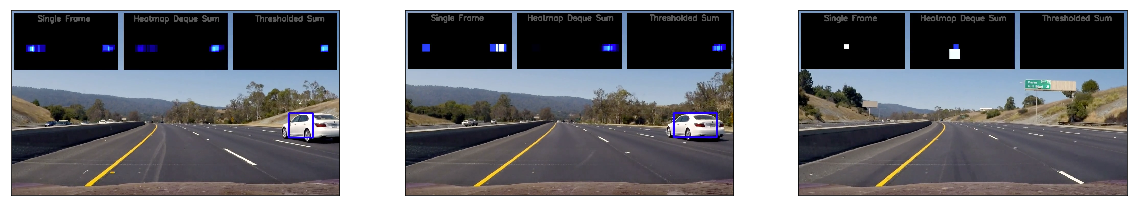

In [16]:
from plot_images import plot_images
images = []
for num in range(1,4):
    file = 'Thresh_image_{}.png'.format(num)
    print("processing file:", file)
    # img = cv2.imread('test_images/' + file)
    image = mpimg.imread('output_images/' + file)
    images.append(image)
plot_images(images, col=3)

### The images above show clips from the final video with the overlay showing how the the deque sum across 20 frames and the thresholding helps eliminate false positives which show on the heatmap for the single frame and the deque.
* Note: The final video does contain several false positives.  These are actually vehicles the classifier identifies in the oncoming lane so alternate methods of filtering such as region of interest etc. seem like a more appropriate method to deal with these than threshold adjustment, aspect ration filtering etc.  After all, the classifier is correctly identifying there are vehicles in the oncoming lane...it simply has difficulty tracking them because they are often partial vehicles obscured byt the center divider etc.


In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_output_video_20.mp4
[MoviePy] Writing video project_output_video_20.mp4


100%|█████████▉| 1260/1261 [13:48<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video_20.mp4 

CPU times: user 12min 27s, sys: 1min 49s, total: 14min 16s
Wall time: 13min 49s


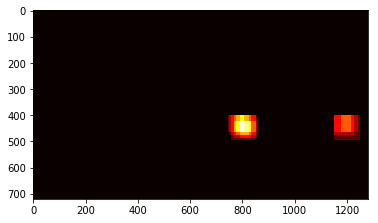

In [19]:
white_output = 'project_output_video_20.mp4'
clip1 = VideoFileClip("project_video.mp4")
cars = VehicleTracker(cc.classifier, cc.scaler, cc.color_space, cc.pix_per_cell,
                      cc.cell_per_block, cc.spatial_size, cc.hist_bins, threshold=20, cspace='RGB2YCrCb')
white_clip = clip1.fl_image(cars.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## **Results**
This project shows it is possible to adequately track nearby vehicles by extracting image features such as gradients and color information alone in combination with a relatively simple classifier. The particular implementation does have a number of limitations and areas for possible improvement.

***Challenges/Improvements***:

* obstruction/vehicle overlap in the image: as can be seen in the video, when two vehicles ovelap in the 2-D image, the simple bounding algorithm being utilized identifies the vehicles as a single car.  This could be remedied in many cases by more sophisticated tracking frame to frame of vehicles.
* false positives: The final video does contain several false positives. These are primarily vehicles the classifier correctly identifies in the oncoming lane which aren't filtered by frame to frame averaging so alternate methods of filtering such as region of interest etc. seem like a more appropriate method to deal with these than threshold adjustment, aspect ratio filtering etc. After all, the classifier is correctly identifying there are vehicles in the oncoming lane...it simply has difficulty tracking them because they are often partial vehicles obscured by the center divider etc.
* stable, accurate vehicle bounding: even with frame to frame averaging, there is some jitter and inaccuracy in the vehicle bounding.  This is partially due to the window sizes in the sliding window approach not precisely identifying vehicle edges. A more sophisticated algorithm to identify where in an initial bounding box the vehicle edges really occur could mitigate this somewhat.  Additionally, due to the frame to frame averaging there can be a delay in identifying a new vehicle entering the image as it takes several frames to develop enough heat to surpass the threshold. 
* weather: poor weather/visibility would make it difficult for the classifier to accurately identify vehicles and could be a major limitation in real world applicability of this simple method.  However, the human vision system is limited by by poor visibility as well
* speed: this type of implementation seems like it might be difficult to run in real time currently on cost effective hardware